In [1]:
import cv2
import matplotlib.pyplot as plt
import imageio
import numpy as np
from utils import extract_keypoints
import math

def load_image(image_path):
    img = cv2.imread(image_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def visualize_image(image):
    """
    image: an output of load_png function
    """
    plt.imshow(image)
    
def save_array_as_image(array, name):
     imageio.imwrite(name, array)
        
def plot_line(line):
    a, b, d = line[0]
    
    Xs = []
    Ys = []
    
    for x in range(1, 548, 10):
        y = (d - x*a)/b
        if y < 407 and y > 0:
            Xs.append(x)
            Ys.append(y)
    
    
    plt.scatter(np.asarray(line[1])[:, 0], np.asarray(line[1])[:, 1], s=30, c='r', marker = 'x')
    plt.plot(Xs, Ys, linewidth = 2, c = 'red')

In [2]:
corner_image = load_image('results/road_nms_2.jpg')

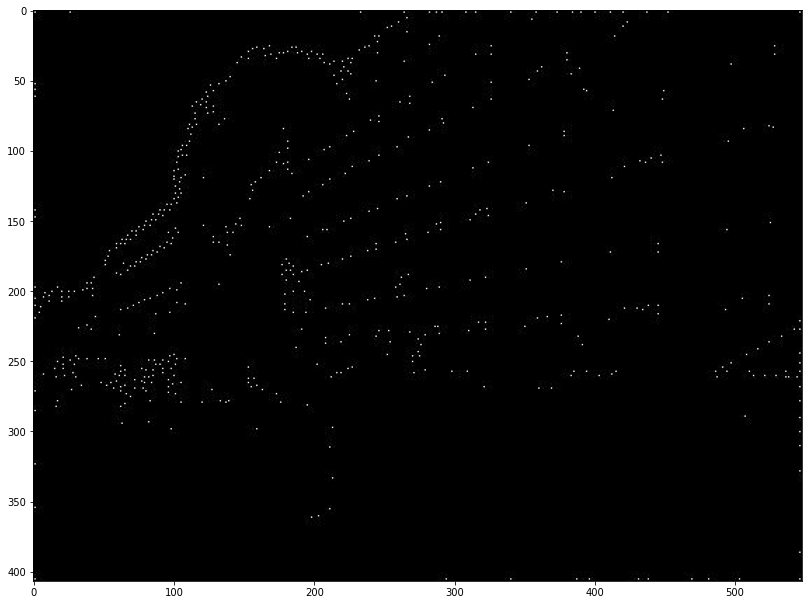

In [3]:
figure, ax = plt.subplots(1, 1)
ax.imshow(corner_image)
figure.set_size_inches(18.5, 10.5)

# Extraction of keypoints from the corner image

In [4]:
import numpy as np

def extract_keypoints(corner_image, thresh=(30,30,30)):
    indices = np.where(np.all(corner_image > thresh, axis=-1))
    return list(zip(indices[1], indices[0]))

In [5]:
keypoints = extract_keypoints(corner_image)

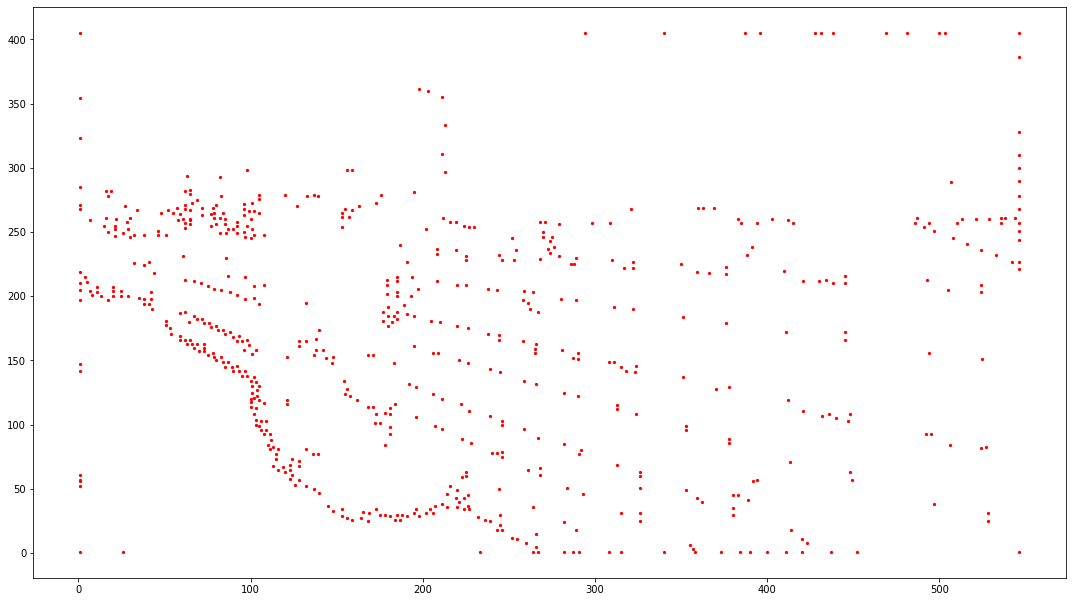

In [6]:
import matplotlib.pyplot as plt

figure, ax = plt.subplots(1, 1)
ax.scatter(np.asarray(keypoints)[:, 0], np.asarray(keypoints)[:, 1], s=5, c='r', marker = 'o')
figure.set_size_inches(18.5, 10.5)

# RANSAC

We are using the adaptive fitting approach to compute the number of iteration $N$.

The `RANSAC` class has a `find_all_fits` method in which we can change the parameters:
- `threshold` -  perpendicular distance within which if a point falls is considered an inlier
- `num_inliers` - the number of inliers that our final models should have at the least

In [7]:
import random

class RANSAC:
    def __init__(self, 
                 corner_image,):
        self.corner_image = corner_image
        self.keypoints = extract_keypoints(corner_image)
        
        self.fits = []
        
    def select_keypoints(self, num_keypoints, previously_chosen_pairs):
        random.seed(42)
        
        new_pair = random.sample(self.keypoints, num_keypoints)
        while tuple(new_pair) in previously_chosen_pairs:
            new_pair = random.sample(self.keypoints, num_keypoints)
        
        return new_pair
    
    def compute_line_parameters(self, keypoint_1, keypoint_2):
        x1, y1 = keypoint_1
        x2, y2 = keypoint_2
        
        # y = mx + c
        m = (y2 - y1)/(x2 - x1) # slope
        c = y2 - m*x2 # intercept
        
        # ax + by = d
        k = 1/(m**2 + 1)**0.5
        a = -m*k
        b = 1*k
        d = c*k
        
        return a, b, d
    
    def get_inliners(self, line_parameters, threshold):
        
        inliers = []
        
        a, b, d = line_parameters
        
        for keypoint in self.keypoints:
            x, y = keypoint
            distance_from_line = abs(a*x + b*y - d)
            
            if distance_from_line <= threshold:
                inliers.append(keypoint)
        
        inliers_percentage = len(inliers)/len(self.keypoints)
        
        return inliers, inliers_percentage
    
    def adaptively_fit(self, 
                       probability, 
                       threshold, 
                       num_inliers = 10,
                       num_keypoints = 2):
        print('\nFITTING!!')
        
        N = float('inf')
        sample_count = 0
        
        inliers_count_milestone = num_inliers
        inliers_milestone = []
        
        print(N, inliers_count_milestone)
        
        fit = ()
        
        previously_chosen_pairs = []
        
        while N > sample_count:
            kp1, kp2 = self.select_keypoints(num_keypoints, previously_chosen_pairs)
            line_parameters = self.compute_line_parameters(kp1, kp2)
            inliers, inliers_percentage = self.get_inliners(line_parameters, threshold)
            
            previously_chosen_pairs.append((kp1, kp2))
            previously_chosen_pairs.append((kp2, kp1))
            
            if len(inliers) > inliers_count_milestone:
                inliers_count_milestone = len(inliers)
                inliers_milestone = inliers.copy()
                
                fit = line_parameters               


                e = 1 - inliers_count_milestone/len(self.keypoints) # outleir percentage
                N = math.log(1 - probability)/(.0001 + math.log(1 - (1 - e)**num_keypoints))
                print(N, inliers_count_milestone)
            
            
            sample_count += 1
            
        
        print('----------------------------------------------------------')
        
        return fit, inliers_milestone
    
    def find_all_fits(self, 
                      threshold,
                      num_inliers = 20,
                      num_fits = 10,
                      num_keypoints = 2,
                      probability = 0.9):
        
        for i in range(num_fits):
            fit, inliers = self.adaptively_fit(probability, threshold, num_inliers, num_keypoints)
            self.keypoints = [keypoint for keypoint in self.keypoints if keypoint not in set(inliers)]
            self.fits.append((fit, inliers))
        

In [28]:
ransac = RANSAC(corner_image)
ransac.find_all_fits(4, num_inliers = 25, num_fits = 9)


FITTING!!
inf 25
772.2495868977198 36
562.0422402071212 42
409.95516330430746 49
363.15896720278994 52
349.3337161953147 53


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


271.4120949106086 60
----------------------------------------------------------

FITTING!!
inf 25
565.604319604986 38
322.8371673177688 50
310.08612720376107 51
----------------------------------------------------------

FITTING!!
inf 25
445.4813060517102 39
348.28784867593225 44
304.5286133899875 47
----------------------------------------------------------

FITTING!!
inf 25
553.9612571467983 32
520.0776469278123 33
369.6515506779191 39
333.84425666780214 41
252.8886831472317 47
----------------------------------------------------------

FITTING!!
inf 25
690.430802235772 26
638.753693066115 27
354.47036384099886 36
----------------------------------------------------------

FITTING!!
inf 25
432.71565952152116 30
298.41956386748126 36
282.24858472914406 37
253.61352091558544 39
----------------------------------------------------------

FITTING!!
inf 25
257.63428696454656 35
----------------------------------------------------------

FITTING!!
inf 25
223.19282424166926 34
-------------

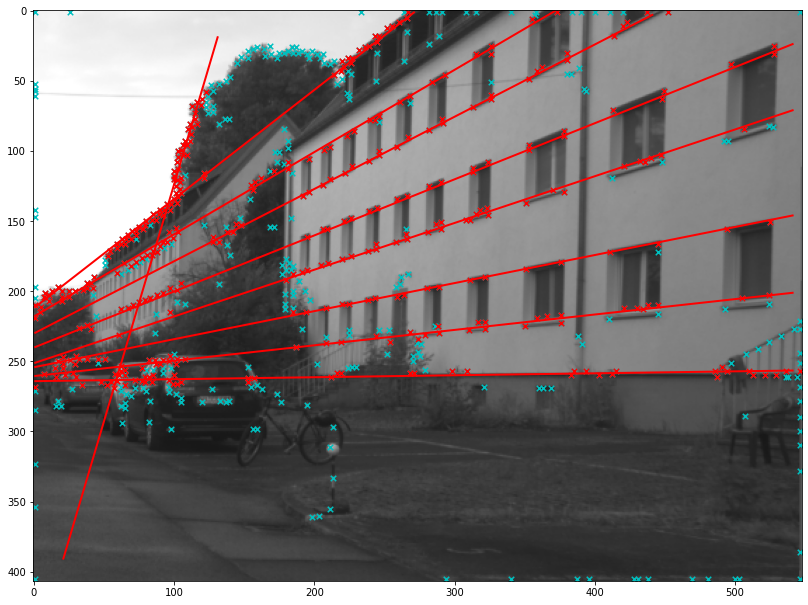

In [29]:
figure, ax = plt.subplots(1, 1)
visualize_image(load_image('road.png'))
plt.scatter(np.asarray(keypoints)[:, 0], np.asarray(keypoints)[:, 1], s=30, c='c', marker = 'x')
for line in ransac.fits:
    plot_line(line)

figure.set_size_inches(18.5, 10.5)

In [31]:
figure.savefig('results/ransac-fitting.png', bbox_inches='tight')